In [81]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
import spacy
import string
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
import logging
import re
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.utils import to_categorical

In [82]:
#Helper Plotting function
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [2]:
#Setting Working Directory
os.chdir('/Users/samk/Box/scrapers/amazon.com/AmazonScraper/Departments/Appliances')

In [4]:
#importing the data
reviews = pd.read_csv('Appliances_reviews.csv')

In [12]:
#Subsetting the data to just the text and rating columns
ratings = reviews.loc[:, ['text','rating']]

In [19]:
#converting all elements of pandas series to str
ratings['text'] = ratings['text'].apply(lambda text: str(text))

In [20]:
#Preprocessing text with Gensim utils
ratings['text_clean'] = ratings['text'].apply(lambda text: gensim.utils.simple_preprocess(text))

In [84]:
#Defining X features and Y labels
X = ratings['text_clean']
y = ratings['rating']

In [85]:
#Converting the dependent variable to categorical
Y_cat = to_categorical(y, 6)

In [102]:
#Splitting data into train and test sets
sentences_train, sentences_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=1000)

In [103]:
#Preprocessing text with Keras Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

In [113]:
#Transforming text to sequences
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

In [114]:
#Defining the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [118]:
#Checking actual sentence with its vocab index representation
print(sentences_train[1])
print(X_train[1])

['give', 'it', 'stars', 'for', 'function', 'and', 'form', 'it', 'easy', 'to', 'install', 'and', 'the', 'water', 'tastes', 'great', 'however', 'for', 'value', 'and', 'heavy', 'handed', 'business', 'practices', 'give', 'it', 'sub', 'star', 'seriously', 'so', 'it', 'not', 'enough', 'that', 'buy', 'refrigerator', 'from', 'ge', 'they', 'need', 'want', 'recurring', 'revenue', 'stream', 'so', 'bad', 'they', 'make', 'me', 'buy', 'their', 'over', 'priced', 'proprietary', 'water', 'filter', 'otherwise', 'my', 'fridge', 'glares', 'at', 'me', 'with', 'red', 'warning', 'message', 'that', 'cannot', 'get', 'rid', 'of', 'that', 'burns', 'me', 'up', 'frankly', 'either', 'reduce', 'the', 'cost', 'allow', 'me', 'to', 'buy', 'an', 'off', 'brand', 'filter', 'or', 'allow', 'me', 'to', 'turn', 'off', 'the', 'warning', 'message', 'know', 'there', 'chance', 'ge', 'reps', 'will', 'never', 'read', 'this', 'but', 'this', 'filter', 'for', 'me', 'is', 'deal', 'killer', 'for', 'future', 'ge', 'appliance', 'purchases

In [107]:
# Identifying the max len of the longest string in the corpus setting the padding sequence
length = ratings['text_clean'].astype(str).map(len)
print (len(ratings.loc[length.argmax(), 'text_clean']))

1527


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  This is separate from the ipykernel package so we can avoid doing imports until


In [111]:
# Padding the sequences to have the same length
#Setting max len at 100 tokens per sequence
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [94]:
#Creating function to load Glove Pretrained model 50d to create the word embedding layer

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [95]:
#Retrieving the embedding matrix
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
     '/Users/samk/Documents/glove/glove.6B.50d.txt',
   tokenizer.word_index, embedding_dim)

In [96]:
# Assessing the number of non zero elements to check the coverage of the vocabulary by the embedding matrix
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size


0.8361118803655497

In [97]:
#Defining our model
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.LSTM(128, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 50)            902750    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 66        
Total params: 995,754
Trainable params: 995,754
Non-trainable params: 0
_________________________________________________________________


Train on 37206 samples, validate on 12402 samples
Epoch 1/10
37206/37206 [==============================] - 191s 5ms/step - loss: 1.2308 - acc: 0.5922 - val_loss: 1.2130 - val_acc: 0.5939
Epoch 2/10
37206/37206 [==============================] - 187s 5ms/step - loss: 1.2291 - acc: 0.5928 - val_loss: 1.2092 - val_acc: 0.5944
Epoch 3/10
37206/37206 [==============================] - 185s 5ms/step - loss: 3.7050 - acc: 0.5381 - val_loss: 1.2106 - val_acc: 0.5926
Epoch 4/10
37206/37206 [==============================] - 185s 5ms/step - loss: 1.3107 - acc: 0.5947 - val_loss: 1.4582 - val_acc: 0.5964
Epoch 5/10
37206/37206 [==============================] - 185s 5ms/step - loss: 1.2831 - acc: 0.5981 - val_loss: 1.2141 - val_acc: 0.5936
Epoch 6/10
37206/37206 [==============================] - 184s 5ms/step - loss: 1.2289 - acc: 0.6001 - val_loss: 1.4667 - val_acc: 0.5955
Epoch 7/10
37206/37206 [==============================] - 185s 5ms/step - loss: 4.1902 - acc: 0.5958 - val_loss: 1.2703 - 

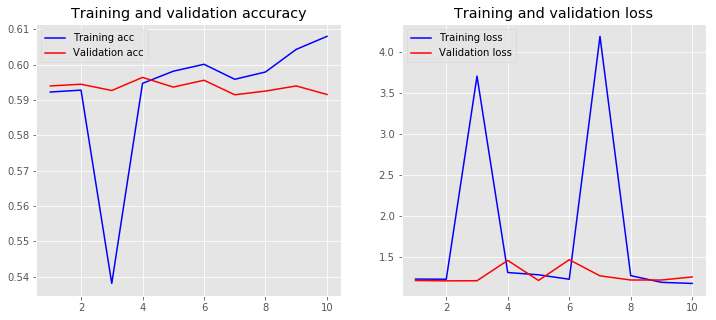

In [99]:
#Training the model and plotting results
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)


In [92]:
y_train

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)